In [1]:
import pickle
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import random
import itertools
import functools
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import gudhi.wasserstein as wasserstein
from torch_topological import nn as topnn

from advtopo import utils
from advtopo import models
from advtopo import pis

In [2]:
device = torch.device("cpu")

In [3]:
ds_train, ds_test = utils.get_torch_datasets()

/home/andrea/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
ds_train

In [4]:
# ds_train[sample_id][0][Homology] is tensor (2, 500)
# First 0 is for input, 1 will give us label
# Notice that it is now transposed compared to before
print(ds_train[0][0][0].shape)
print(ds_train[0][0][1].shape)

torch.Size([2, 500])
torch.Size([2, 500])


### Settings for PIs

In [5]:
x_lim = [0, 1]
y_lim = [0, 1]
x_n = 50
y_n = 50

weighted = True

sigma = torch.tensor(0.01)

#### Getting the centers

In [6]:
centers = pis.get_centers(x_lim, y_lim, x_n, y_n)

In [7]:
centers.shape

torch.Size([2500, 1, 2])

#### Get mean/var vectors

In [8]:
Xs = []
ys = []
for (X, y) in ds_train:

  H0 = pis.gauss_filt(pis.rot_dg(X[0].T, device), centers, sigma, weight=weighted).cpu().numpy()
  H1 = pis.gauss_filt(pis.rot_dg(X[1].T, device), centers, sigma, weight=weighted).cpu().numpy()

  Xs.append([H0, H1])
  ys.append(y.numpy())

: 

In [ ]:
XX = np.zeros((len(Xs), x_n*y_n*2))

for i in range(len(Xs)):
  XX[i] = np.concatenate((Xs[i][0], Xs[i][1]))

In [ ]:
scaler = StandardScaler()
XX = scaler.fit_transform(XX)

In [ ]:
scaler.mean_

array([4.54728396e-04, 5.66694133e-05, 1.09682828e-07, ...,
       3.01873171e-06, 9.11835519e-08, 4.47212948e-11])

In [ ]:
scaler.var_

array([7.23515922e-04, 1.12367670e-05, 4.20940995e-11, ...,
       2.90280458e-08, 2.89839241e-11, 6.99698404e-18])

### Getting PIs datasets

In [ ]:
Xs_train, ys_train = utils.convert_orbit_to_pi_dataset(ds_train, device, centers, sigma, scaler.mean_, scaler.var_, weighted)

In [ ]:
trainset = utils.PIDataset(Xs_train, ys_train)

In [ ]:
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

#### Train

In [ ]:
epochs = 10
# Model , Optimizer, Loss
model = models.Model_PI(input_shape=Xs_train[0].shape[0]).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, eps=1e-04)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
losses = []
for i in range(epochs):
  for j,(x_t,y_t) in enumerate(trainloader):
    
    #calculate output
    output = model(x_t.float())

    y_t = y_t.long()
    #calculate loss
    loss = loss_fn(output, y_t)
 
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%1 == 0:
    losses.append(loss)
    print("epoch {}\tloss : {}".format(i,loss))

epoch 0	loss : 1.256534457206726
epoch 1	loss : 0.6050912737846375
epoch 2	loss : 0.44325053691864014
epoch 3	loss : 0.3875695466995239
epoch 4	loss : 0.357699990272522
epoch 5	loss : 0.3407130241394043
epoch 6	loss : 0.3281669616699219
epoch 7	loss : 0.3240552544593811
epoch 8	loss : 0.3144930601119995
epoch 9	loss : 0.3084944784641266


### Test

In [ ]:
Xs_test, ys_test = utils.convert_orbit_to_pi_dataset(ds_test, device, centers, sigma, scaler.mean_, scaler.var_, weighted)

In [ ]:
testset = utils.PIDataset(Xs_test, ys_test)

In [ ]:
testloader = DataLoader(testset,batch_size=64,shuffle=False)

In [ ]:
test_loss, correct, preds, ground_truth = models.test(testloader, model, loss_fn, device)

In [ ]:
correct

0.8733333333333333

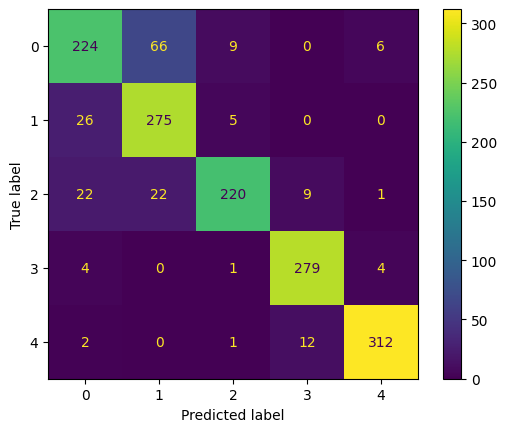

In [ ]:
preds = torch.concat(preds)
ground_truth = torch.concat(ground_truth)

cm = confusion_matrix(ground_truth.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [ ]:
if weighted:
    torch.save(model.state_dict(), "./model_pi_weighted")
else:
    torch.save(model.state_dict(), "./model_pi_unweighted")

In [ ]:
model_config = {"x_n": x_n, "y_n": y_n, "centers": centers, "sigma": sigma, "mean":scaler.mean_, "var":scaler.var_, "weighted":weighted}

if weighted:
    with open('model_config_weighted', 'wb') as handle:
        pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('model_config_unweighted', 'wb') as handle:
        pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
weighted

True